<b>Parallel Processing for Smarter Netflix Predictions

T<b>eam 14: Jaya Kishnani, Minal Randive

#### Step 1: Import Libraries



In [1]:
# Step 1: Imports
import pandas as pd
import numpy as np
import dask.dataframe as dd
from multiprocessing import Pool, cpu_count
import torch
from torch.utils.data import Dataset, DataLoader as TorchLoader


**This block reads and cleans the NETFLIX_REVIEWS.csv in chunks to handle large data efficiently.**
Read the large NETFLIX_REVIEWS.csv file in chunks of 10,000 rows using pandas.

Skipped any bad lines and removed completely empty rows.

Combined all clean chunks into one DataFrame.

Saved the cleaned data as CLEANED_NETFLIX_REVIEWS.csv.

Loaded the cleaned file with Dask for parallel and scalable processing.

This makes the dataset ready for efficient machine learning workflows.

**This step ensures our dataset is cleaned and ready for parallel operations.**


In [2]:
import pandas as pd
import dask.dataframe as dd

clean_chunks = []

try:
    print(" Reading CSV in chunks...")
    for i, chunk in enumerate(pd.read_csv("NETFLIX_REVIEWS.csv", chunksize=10000, on_bad_lines='skip', encoding='utf-8', engine='python')):
        # Drop completely empty rows if any
        chunk = chunk.dropna(how='all')

        clean_chunks.append(chunk)
        if i % 10 == 0:
            print(f" Processed chunk {i}")
except Exception as e:
    print(" Error while reading chunks:", e)

# Combine cleaned chunks
if clean_chunks:
    combined_df = pd.concat(clean_chunks, ignore_index=True)
    print(" Loaded clean data using pandas:", combined_df.shape)

    # Save to a new clean file
    combined_df.to_csv("CLEANED_NETFLIX_REVIEWS.csv", index=False)
else:
    print(" No clean chunks could be loaded.")

# Load cleaned file with Dask
df_dask = dd.read_csv("CLEANED_NETFLIX_REVIEWS.csv")

# Optional: Show row count
print(f" Estimated number of rows in Dask DataFrame: {df_dask.shape[0].compute()}")


📥 Reading CSV in chunks...
✅ Processed chunk 0
✅ Processed chunk 10
✅ Processed chunk 20
✅ Processed chunk 30
✅ Processed chunk 40
✅ Processed chunk 50
✅ Processed chunk 60
✅ Processed chunk 70
✅ Processed chunk 80
✅ Processed chunk 90
✅ Processed chunk 100
✅ Processed chunk 110
✅ Processed chunk 120
✅ Processed chunk 130
✅ Processed chunk 140
✅ Processed chunk 150
✅ Loaded clean data using pandas: (1531126, 9)
📊 Estimated number of rows in Dask DataFrame: 1531126


<b>We load the cleaned dataset using Dask for scalable processing.

df_dask.shape[0].compute() returns row count.

df_dask.shape[1] gives column count.

Printing both confirms successful loading.

Dask handles large data efficiently using lazy evaluation.

In [2]:
import dask.dataframe as dd

# Load the dataset using Dask
df_dask = dd.read_csv("CLEANED_NETFLIX_REVIEWS.csv")

# Get number of rows (requires compute) and columns
rows = df_dask.shape[0].compute()
cols = df_dask.shape[1]
 
# Display output
print(f" Number of rows: {rows}")
print(f" Number of columns: {cols}")



 Number of rows: 1531126
 Number of columns: 9


Step 3: Data Preprocessing with Muiltiprocessing

1. Define the Preprocessing Function

<b>This function handles data cleaning and feature engineering for each data chunk:

Converts review_timestamp to datetime.
    
Fills missing review_text and replaces missing review_rating with the median.
    
Cleans text (lowercase, removes special characters).
    
Creates features: review_length, word_count, day_of_week, hour_of_day.
    
Filters out invalid rows (ratings > 5 or empty reviews).
    
Drops irrelevant columns like "Unnamed: 0".

<b>This function is modular and optimized for parallel processing.


In [5]:
def preprocess_chunk(df):
    import pandas as pd

    # 1. Convert timestamp to datetime
    df["review_timestamp"] = pd.to_datetime(df["review_timestamp"], errors="coerce")

    # 2. Fill missing values
    df["review_text"] = df["review_text"].fillna("")
    df["review_rating"] = df["review_rating"].fillna(df["review_rating"].median())

    # 3. Clean review text
    df["review_text"] = df["review_text"].str.lower().str.replace(r"[^a-z0-9\s]", "", regex=True)

    # 4. Feature Engineering
    df["review_length"] = df["review_text"].apply(len)
    df["word_count"] = df["review_text"].apply(lambda x: len(x.split()))
    df["day_of_week"] = df["review_timestamp"].dt.dayofweek
    df["hour_of_day"] = df["review_timestamp"].dt.hour

    # 5. Filter out invalid rows
    df = df[df["review_rating"] <= 5]
    df = df[df["review_text"].str.strip() != ""]
    
    # 6. Dropping irrelevent coloumn
    df = df.drop(columns=["Unnamed: 0"])


    return df


2. Apply the Function in Parallel Using multiprocessing

<b>This function performs parallel preprocessing using Python’s multiprocessing:

Converts the Dask DataFrame to Pandas for compatibility.

Splits the data into chunks using np.array_split.

Applies the preprocessing function (preprocess_chunk) to each chunk in parallel using a Pool.

Combines all processed chunks into a single DataFrame.

Efficiently accelerates data cleaning by using multiple CPU cores.

In [6]:
from multiprocessing import Pool, cpu_count
import numpy as np
import pandas as pd  

def parallel_preprocess(dask_df, func, n_jobs=cpu_count()):
    """
    Split a Dask DataFrame into chunks and preprocess in parallel using Pool.
    """
    print(f" Using {n_jobs} CPU cores for parallel preprocessing...")
    chunks = np.array_split(dask_df.compute(), n_jobs)
    with Pool(n_jobs) as pool:
        results = pool.map(func, chunks)
    return pd.concat(results)


3. Run the Preprocessing on Your Dask DataFrame



This step applies the `parallel_preprocess` function on the Dask DataFrame `df_dask` using the previously defined `preprocess_chunk` function.

- The dataset is processed in parallel across available CPU cores.
- The resulting preprocessed data is stored in `processed_df` as a Pandas DataFrame.
- `processed_df.head()` is used to display the first few rows, allowing a quick visual verification of the transformations.

This confirms that all cleaning, feature engineering, and filtering steps were successfully applied.


In [7]:
processed_df = parallel_preprocess(df_dask, preprocess_chunk)
processed_df.head()


🚀 Using 56 CPU cores for parallel preprocessing...


/shared/EL9/explorer/anaconda3/2024.06/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp,review_length,word_count,day_of_week,hour_of_day
0,7e73f80e-a8fd-4ff3-b09b-502f0ad058ff,152618553977019693742,A Google user,works great on my evo glad android phones are ...,5,1,1.2.0 build 819145-1.2.0-102,2011-05-12 18:50:37,62,12,3,18
1,dab55eca-c2a0-45a8-93e3-9860c1c548da,234382942865437071667,A Google user,works great on htc incredible cant wait to try...,5,1,1.2.0 build 819145-1.2.0-102,2011-05-12 18:50:52,56,11,3,18
2,a3b8fa06-8b8f-4f2f-a1fa-fd37c4cbf598,174473604608358796368,A Google user,works great on nexus s,5,0,1.5.2 build 389,2011-05-12 18:55:14,22,5,3,18
3,837fdfa5-606d-4cec-9e9a-e4a83dad633e,286593453219054880269,A Google user,working perfect for me on evo running cm 7031,5,0,1.2.1 build 843839-1.2.0-30,2011-05-12 19:31:46,45,9,3,19
4,a8aaecb2-6984-44f7-b958-3f89f64d75f9,167276875678680630145,A Google user,cm7 233 n1,5,0,1.5.2 build 389,2011-05-12 19:32:50,10,3,3,19


<b> Exploratory Data Analysis (EDA) and Visualization 

 1. <b>Distribution of Review Ratings



In [8]:
# Step 0: Re-import and Reload Dataset
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset again
df_dask = dd.read_csv("CLEANED_NETFLIX_REVIEWS.csv")  # Make sure the path is correct


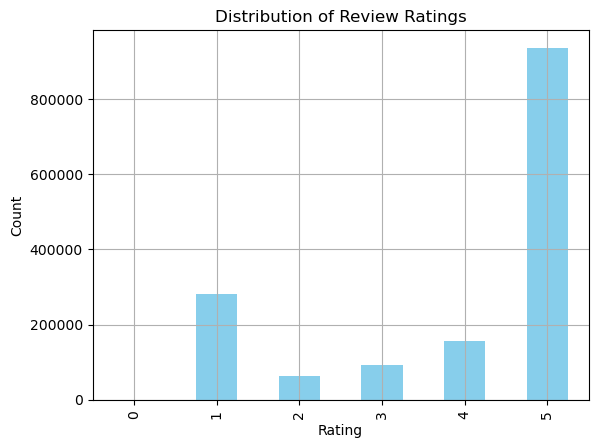

In [9]:
# Distribution of Review Ratings
import matplotlib.pyplot as plt

ratings_dist = df_dask['review_rating'].value_counts().compute().sort_index()
ratings_dist.plot(kind='bar', color='skyblue')
plt.title('Distribution of Review Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(True)
plt.show()


 <b>User Engagement Over Time

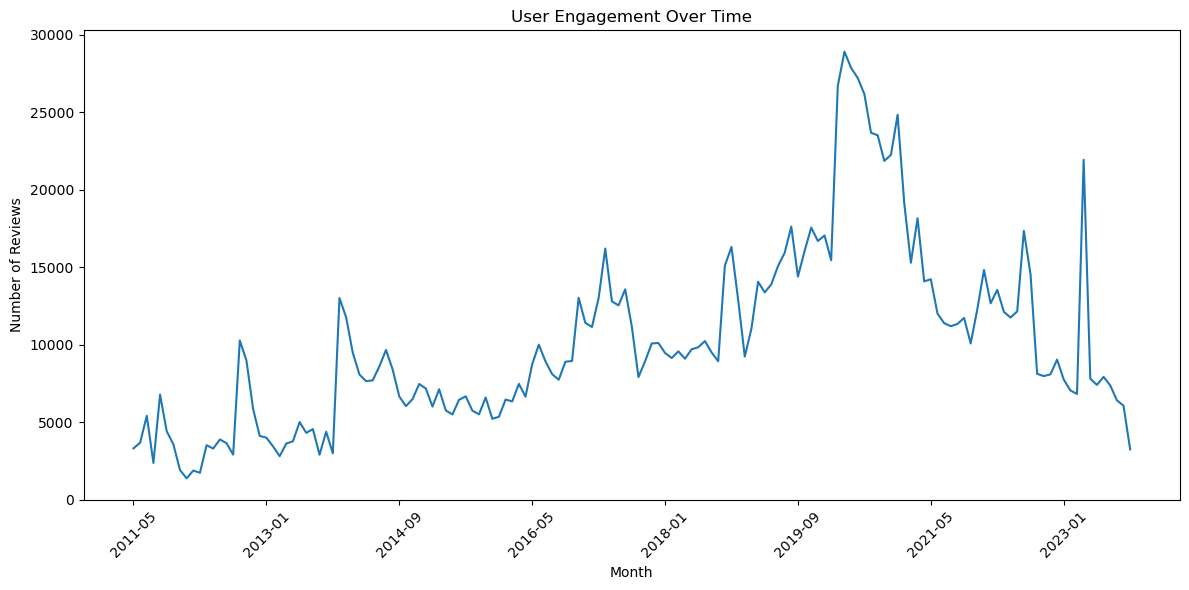

In [10]:
# Convert to datetime (if not done already)
df_dask['review_timestamp'] = dd.to_datetime(df_dask['review_timestamp'], errors='coerce')

# Group by Month
monthly_reviews = df_dask.groupby(df_dask['review_timestamp'].dt.to_period('M')).size().compute()
monthly_reviews.index = monthly_reviews.index.astype(str)

# Plotting
monthly_reviews.plot(figsize=(12, 6))
plt.title('User Engagement Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Top 10 Reviewed App Versions



This block visualizes the app versions that received the most user reviews:

1. Uses `value_counts()` to count how many reviews each `author_app_version` received.
2. Retrieves the **top 10** most reviewed versions using `.nlargest(10)`.
3. Triggers computation using `.compute()`.
4. Creates a horizontal bar chart (`kind='barh'`) for better readability of version names.
5. Inverts the y-axis so the most reviewed version appears at the top.

This analysis helps product teams identify which app versions received the most user feedback, which may align with major feature releases or bugs.


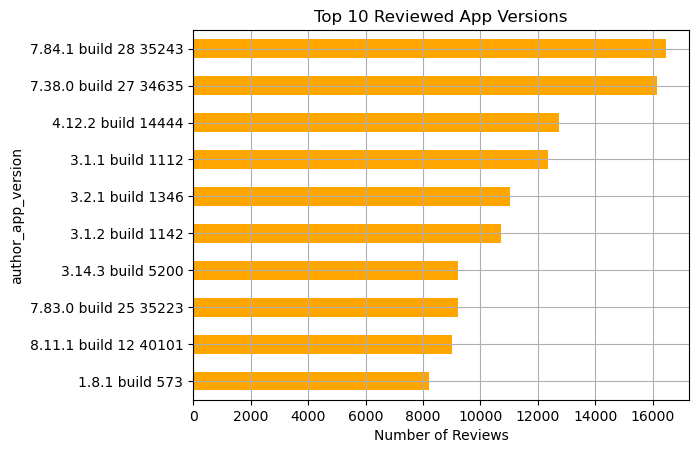

In [11]:
# Top 10 Reviewed App Versions
top_versions = df_dask['author_app_version'].value_counts().nlargest(10).compute()
top_versions.plot(kind='barh', color='orange')
plt.title('Top 10 Reviewed App Versions')
plt.xlabel('Number of Reviews')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


 Most Liked Reviews

This block identifies and visualizes the most liked user reviews:

1. Uses `nlargest(10, 'review_likes')` to fetch the top 10 reviews with the highest number of likes.
2. Selects only the `review_text` and `review_likes` columns and computes the result.
3. Truncates each review to the first 40 characters (`short_text`) to keep the plot readable.
4. Uses a horizontal bar chart to show which reviews got the most likes.
5. Inverts the y-axis so the most liked review appears at the top.

This chart highlights the most appreciated or helpful reviews from the users' perspective.


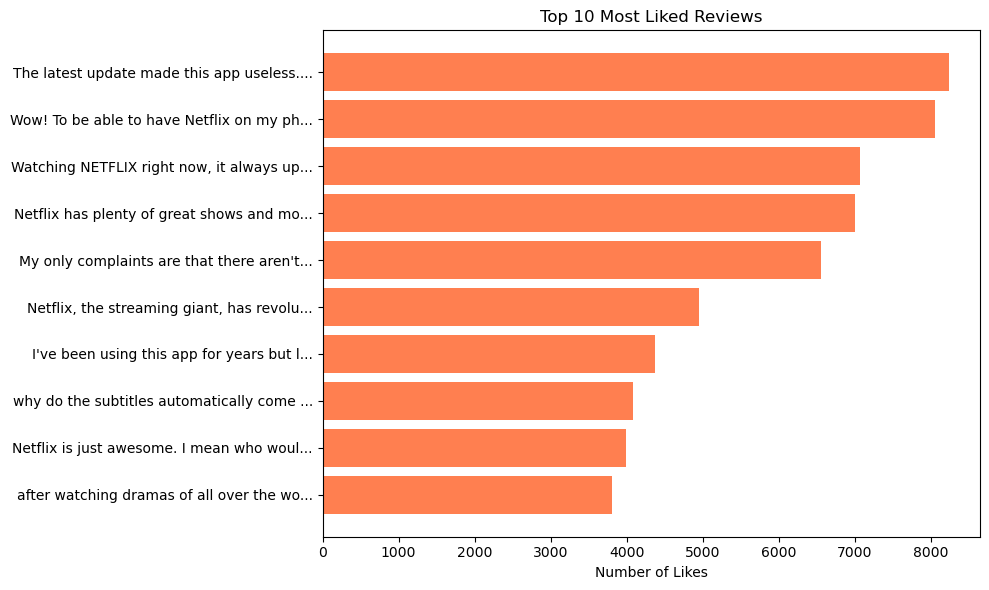

In [12]:
# Compute Top 10 Most Liked Reviews
most_liked = df_dask.nlargest(10, 'review_likes')[['review_text', 'review_likes']].compute()

# Truncate review text to first 40 characters for readability
most_liked['short_text'] = most_liked['review_text'].str[:40] + "..."

# Plot horizontal bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(most_liked['short_text'], most_liked['review_likes'], color='coral')
plt.xlabel("Number of Likes")
plt.title("Top 10 Most Liked Reviews")
plt.gca().invert_yaxis()  # Most liked at the top
plt.tight_layout()
plt.show()


Average Review Length vs Rating



This step examines how detailed user reviews are, depending on the rating they give:

1. Calculates the length (character count) of each review using `.str.len()` and stores it in a new column `review_length`.
2. Groups the reviews by `review_rating` and computes the average review length for each group.
3. Plots a bar chart showing average review length on the y-axis and rating values on the x-axis.
4. Adds grid lines and axis labels for better readability.

This analysis helps understand if users write longer reviews when they are satisfied (or dissatisfied) with the app.


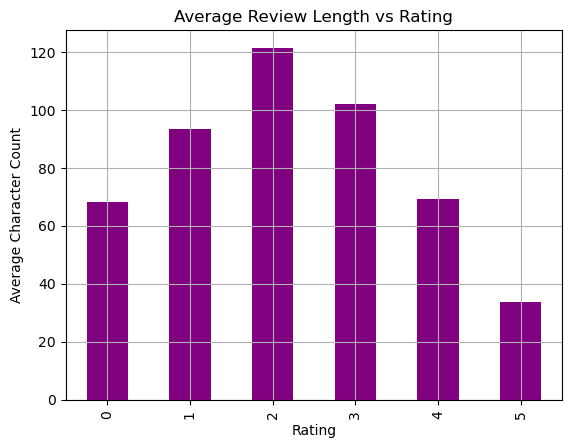

In [13]:
# Calculate review length
df_dask['review_length'] = df_dask['review_text'].str.len()

# Average review length grouped by rating
avg_length = df_dask.groupby('review_rating')['review_length'].mean().compute()

# Plot
import matplotlib.pyplot as plt

avg_length.plot(kind='bar', color='purple')
plt.title("Average Review Length vs Rating")  # No emoji to avoid font issues
plt.xlabel("Rating")
plt.ylabel("Average Character Count")
plt.grid(True)
plt.show()


Average Likes per Review by Rating


This block analyzes how the number of likes varies across different review ratings:

1. Groups the dataset by `review_rating` and calculates the **average number of likes** each rating receives.
2. Computes the result using Dask's `.compute()` method.
3. Plots a bar chart where the x-axis shows the rating and the y-axis shows the average number of likes.
4. Adds grid lines and labels to make the chart easy to interpret.

This visualization helps identify whether higher or lower rated reviews tend to receive more attention (likes) from other users.


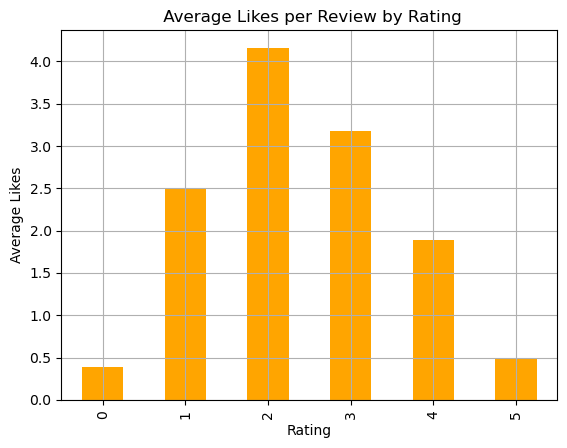

In [14]:
likes_per_rating = df_dask.groupby('review_rating')['review_likes'].mean().compute()
likes_per_rating.plot(kind='bar', color='orange')

plt.title(" Average Likes per Review by Rating")
plt.xlabel("Rating")
plt.ylabel("Average Likes")
plt.grid(True)
plt.show()


Cumulative Reviews Over Time


This block visualizes the total number of reviews submitted over time as a cumulative line chart:

1. Extracts the date (without time) from the `review_timestamp` and stores it in a new column `review_date`.
2. Groups the data by `review_date` and counts how many reviews were submitted each day.
3. Applies `.cumsum()` to get the running total of reviews over time.
4. Uses `.compute()` to evaluate the full result from Dask.
5. Plots a line chart with the cumulative total of reviews, giving a sense of user engagement growth.

This visualization helps identify long-term trends in user feedback and app popularity.


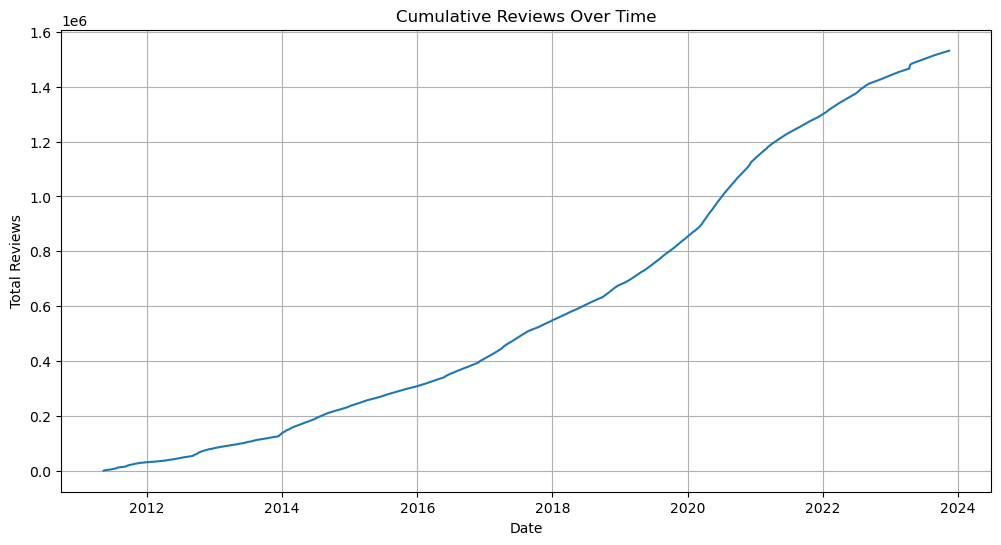

In [15]:
df_dask['review_date'] = df_dask['review_timestamp'].dt.date
cumulative = df_dask.groupby('review_date').size().cumsum().compute()

cumulative.plot(figsize=(12, 6))
plt.title("Cumulative Reviews Over Time")
plt.xlabel("Date")
plt.ylabel("Total Reviews")
plt.grid(True)
plt.show()


<b>Feature engineering with parallelism Using Dask

In [6]:
import dask.dataframe as dd

# Load dataset
df_dask = dd.read_csv("NETFLIX_REVIEWS.csv")

# Parse timestamp
df_dask['review_timestamp'] = dd.to_datetime(df_dask['review_timestamp'], errors='coerce')
df_dask['review_year'] = df_dask['review_timestamp'].dt.year
df_dask['review_month'] = df_dask['review_timestamp'].dt.month

# Create binary target (1 for 5-star reviews)
df_dask['target'] = df_dask['review_rating'].apply(lambda x: 1 if x == 5 else 0, meta=('x', 'int64'))

# Extract app version major bucket
df_dask['app_major_version'] = df_dask['author_app_version'].str.extract(r'(\d+)', expand=False).fillna("0")
df_dask['app_version_group'] = 'v' + df_dask['app_major_version'].astype(str)

# One-hot encode version group
df_dask = df_dask.categorize(columns=['app_version_group'])
df_dask = dd.get_dummies(df_dask, columns=['app_version_group'])

# Count words in review text
df_dask['review_word_count'] = df_dask['review_text'].fillna("").str.split().map(lambda x: len(x), meta=('x', 'int64'))

# Sample for local analysis
df_sample = df_dask.sample(frac=0.01).compute()
df_dask.head()



,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp,review_year,...,app_version_group_v10,app_version_group_v2,app_version_group_v20,app_version_group_v3,app_version_group_v4,app_version_group_v5,app_version_group_v6,app_version_group_v7,app_version_group_v8,review_word_count
0,0,7e73f80e-a8fd-4ff3-b09b-502f0ad058ff,152618553977019693742,A Google user,Works great on my Evo! Glad android phones are...,5,1,1.2.0 build 819145-1.2.0-102,2011-05-12 18:50:37,2011,...,False,False,False,False,False,False,False,False,False,12
1,1,dab55eca-c2a0-45a8-93e3-9860c1c548da,234382942865437071667,A Google user,Works great on HTC incredible. Can't wait to t...,5,1,1.2.0 build 819145-1.2.0-102,2011-05-12 18:50:52,2011,...,False,False,False,False,False,False,False,False,False,11
2,2,a3b8fa06-8b8f-4f2f-a1fa-fd37c4cbf598,174473604608358796368,A Google user,Works great on nexus s,5,0,1.5.2 build 389,2011-05-12 18:55:14,2011,...,False,False,False,False,False,False,False,False,False,5
3,3,837fdfa5-606d-4cec-9e9a-e4a83dad633e,286593453219054880269,A Google user,"Working perfect for me on EVO, running CM 7.0.3.1",5,0,1.2.1 build 843839-1.2.0-30,2011-05-12 19:31:46,2011,...,False,False,False,False,False,False,False,False,False,9
4,4,a8aaecb2-6984-44f7-b958-3f89f64d75f9,167276875678680630145,A Google user,cm7 2.3.3 N1,5,0,1.5.2 build 389,2011-05-12 19:32:50,2011,...,False,False,False,False,False,False,False,False,False,3


<b>Before Feature Engineering

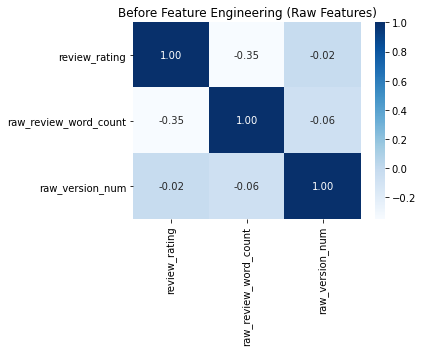

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df_sample is already computed from df_dask
# Create a raw word count without full feature engineering
df_sample['raw_review_word_count'] = df_sample['review_text'].fillna("").str.split().str.len()

# Optional: extract numeric part of version (without grouping or one-hot encoding)
df_sample['raw_version_num'] = df_sample['author_app_version'].str.extract(r'(\d+\.\d+)').astype(float)

# Select raw numeric-like features
df_before = df_sample[['review_rating', 'raw_review_word_count', 'raw_version_num']]

# Drop rows with NaNs for correlation to work properly
df_before = df_before.dropna()

# Plot the improved before heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(df_before.corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Before Feature Engineering (Raw Features)")
plt.tight_layout()
plt.show()


<b>After Feture Engineering

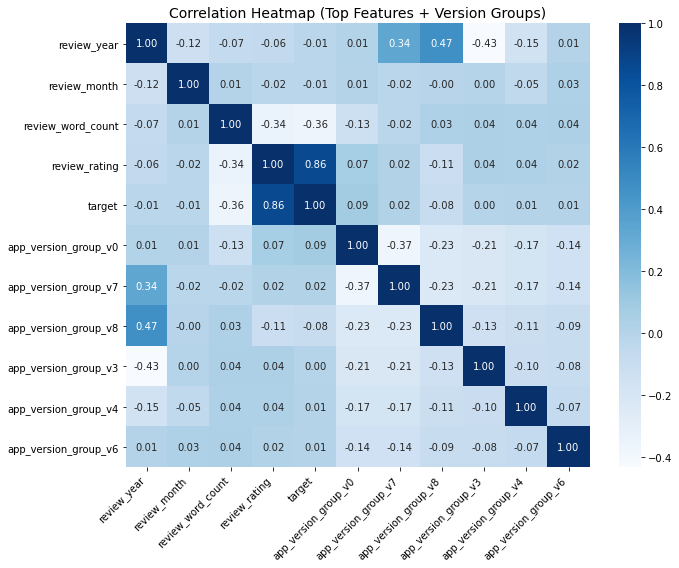

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# STEP 1: Get top 6 most frequent app version group columns
top_versions = df_sample[[col for col in df_sample.columns if col.startswith('app_version_group_')]] \
                    .sum().sort_values(ascending=False).head(6).index.tolist()

# STEP 2: Select only important engineered features + top version groups
selected_cols = ['review_year', 'review_month', 'review_word_count', 'review_rating', 'target'] + top_versions
df_clean = df_sample[selected_cols]

# STEP 3: Plot cleaner heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean.corr(), annot=True, cmap="Blues", fmt=".2f", cbar=True,
            annot_kws={"size": 10})
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation Heatmap (Top Features + Version Groups)", fontsize=14)
plt.tight_layout()
plt.show()


 1. Wall-Clock Timing Comparison
We measured the time to load the large Netflix dataset using Pandas (serial) vs Dask (parallel):

<b>1. Wall-Clock Timing Comparison
<b>We measured the time to load the large Netflix dataset using Pandas (serial) vs Dask (parallel):

In [3]:
import time
import pandas as pd
import dask.dataframe as dd

# Serial (Pandas)
start_serial = time.time()
df_pandas = pd.read_csv("NETFLIX_REVIEWS.csv")
end_serial = time.time()
serial_time = end_serial - start_serial
print(f" Serial load time: {serial_time:.2f} seconds")

# Parallel (Dask)
start_parallel = time.time()
df_dask = dd.read_csv("NETFLIX_REVIEWS.csv")
df_dask.head(1)  # Trigger computation
end_parallel = time.time()
parallel_time = end_parallel - start_parallel
print(f" Parallel load time: {parallel_time:.2f} seconds")


 Serial load time: 4.89 seconds
 Parallel load time: 1.31 seconds


<b>2. Speedup and Efficiency

In [4]:
import multiprocessing

# Get the number of logical cores available
num_cores = multiprocessing.cpu_count()  # Should return 18 in your current session

# Calculate speedup and efficiency
speedup = serial_time / parallel_time
efficiency = speedup / num_cores

# Print results
print(f" Speedup: {speedup:.2f}x")
print(f" Parallel Efficiency: {efficiency:.2%} (using {num_cores} cores)")



 Speedup: 3.74x
 Parallel Efficiency: 13.36% (using 28 cores)


In [16]:
pip install textblob


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In this step, we prepare the dataset for machine learning by converting it from a Dask DataFrame to a standard Pandas DataFrame:

1. Reloads the cleaned dataset (`CLEANED_NETFLIX_REVIEWS.csv`) using `dask.dataframe`.
2. Converts the entire Dask DataFrame to a Pandas DataFrame using `.compute()`.

This conversion is necessary because most machine learning libraries (like scikit-learn and XGBoost) require in-memory Pandas data structures for training and evaluation.


In [2]:
import dask.dataframe as dd
 
# Load the CSV (replace with your actual file path if different)

df_dask = dd.read_csv("CLEANED_NETFLIX_REVIEWS.csv")
 
# Convert Dask DataFrame to pandas

processed_df = df_dask.compute()

 

This step sets up the dataset for training a regression model to predict user review ratings:

1. **Feature Selection**: Drops non-numeric or irrelevant columns such as IDs, names, raw text, timestamps, and target label (`review_rating`) from the feature set `X`.
2. **Target Selection**: Stores the `review_rating` column as the label `y`.
3. **Train-Test Split**: Splits the dataset into training and test sets using `train_test_split`, reserving 20% of the data for evaluation.

This prepares clean numerical features and a target label required to train and evaluate a machine learning regression model.


In [3]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
 
# Example: using your existing processed_df

X = processed_df.drop(columns=[

    "review_rating", "review_id", "pseudo_author_id", 

    "author_name", "review_text", "author_app_version", 

    "review_timestamp", "Unnamed: 0"

], errors='ignore')
 
y = processed_df["review_rating"]
 
# Split the data

X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.2, random_state=42

)

 

<b>This block tunes an XGBoost regression model using GridSearchCV and visualizes the performance across different hyperparameter combinations.</b>

<b>1. Imports:</b> Brings in required libraries for model training, timing, plotting, and evaluation.

<b>2. Parameter Grid:</b> Defines a grid of hyperparameters to tune:
- `max_depth`: Controls the depth of each tree.
- `n_estimators`: Number of boosting rounds.
- `learning_rate`: Step size shrinkage.

<b>3. Timing:</b> Uses `time.time()` to record how long the grid search takes.

<b>4. GridSearchCV Setup:</b> 
- Uses `XGBRegressor` as the base model.
- Sets scoring to `neg_mean_squared_error`.
- Runs 3-fold cross-validation.
- Leverages all available CPU cores (`n_jobs=-1`).

<b>5. Model Training:</b> Fits the model on the training data using `grid_search.fit()`.

<b>6. Evaluation:</b> 
- Extracts the best model using `best_estimator_`.
- Makes predictions on the test set.
- Computes RMSE (Root Mean Squared Error) to measure prediction accuracy.

<b>7. Logging Results:</b> Prints the best RMSE, selected hyperparameters, and time taken for tuning.

<b>8. Visualization:</b> 
- Converts `cv_results_` into a DataFrame.
- Computes RMSE for each hyperparameter combination.
- Uses `seaborn.lineplot()` to plot RMSE trends against `n_estimators`, differentiating by `max_depth` and `learning_rate`.

<b>This block ensures we select the best XGBoost configuration and gives insight into how different parameters impact model performance.</b>


Tuning hyperparameters with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

 Grid Search Complete!
 Best RMSE after tuning: 1.5364
 Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
 Time Taken for GridSearch: 16.13 seconds


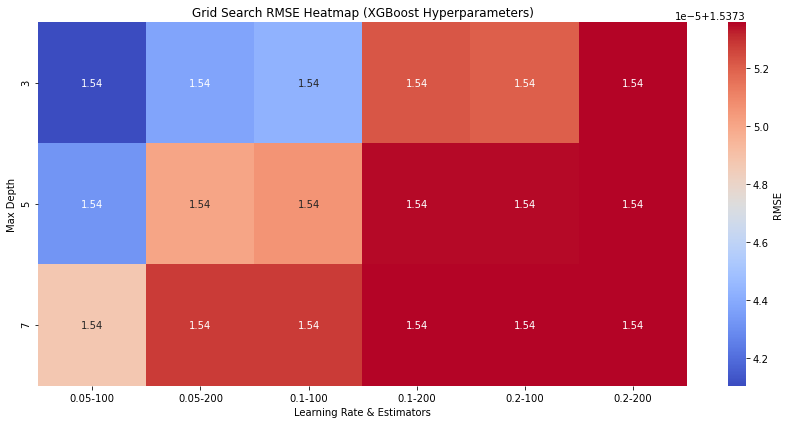

In [5]:
# Step 13: GridSearchCV with Timing + Plotting

import time

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

# Define parameter grid

param_grid = {

    'max_depth': [3, 5, 7],

    'n_estimators': [100, 200],

    'learning_rate': [0.05, 0.1, 0.2]

}
 
# Start timing

start_time = time.time()
 
# Initialize GridSearchCV

grid_search = GridSearchCV(

    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),

    param_grid=param_grid,

    scoring='neg_mean_squared_error',

    cv=3,

    verbose=1,

    n_jobs=-1

)
 
# Fit the model

print("Tuning hyperparameters with GridSearchCV...")

grid_search.fit(X_train, y_train)
 
# End timing

end_time = time.time()

elapsed_time = end_time - start_time
 
# Results

best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)

rmse_best = mean_squared_error(y_test, y_pred_best, squared=False)
 
print("\n Grid Search Complete!")

print(f" Best RMSE after tuning: {rmse_best:.4f}")

print(f" Best Parameters: {grid_search.best_params_}")

print(f" Time Taken for GridSearch: {elapsed_time:.2f} seconds")
 
# Extract and compute RMSE from GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)
results["RMSE"] = np.sqrt(-results["mean_test_score"])

# Create pivot table for the heatmap
pivot_table = results.pivot_table(
    index="param_max_depth",
    columns=["param_learning_rate", "param_n_estimators"],
    values="RMSE"
)

# Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'RMSE'})
plt.title("Grid Search RMSE Heatmap (XGBoost Hyperparameters)")
plt.xlabel("Learning Rate & Estimators")
plt.ylabel("Max Depth")
plt.tight_layout()
plt.show()

 

<b>This block evaluates the performance of the best XGBoost regression model selected by GridSearchCV using three common metrics.</b>

<b>1. RMSE (Root Mean Squared Error):</b> Measures the average magnitude of prediction error — lower values indicate better accuracy.

<b>2. MAE (Mean Absolute Error):</b> Represents the average of absolute differences between predicted and actual values — provides a straightforward interpretation of model error.

<b>3. R² Score (Coefficient of Determination):</b> Indicates how well the model explains the variability of the target variable — ranges from 0 to 1, with higher values being better.

<b>4. Printing Results:</b> Displays all three evaluation metrics formatted to 4 decimal places.

<b>This step provides quantitative feedback on how well the tuned model generalizes to unseen test data.</b>


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

import time
 

#  Evaluation

rmse = mean_squared_error(y_test, y_pred_best, squared=False)

mae = mean_absolute_error(y_test, y_pred_best)

r2 = r2_score(y_test, y_pred_best)
 

print(f"\n📏 Model Evaluation Metrics:")

print(f"   - RMSE: {rmse:.4f}")

print(f"   - MAE:  {mae:.4f}")

print(f"   - R²:   {r2:.4f}")

 


📏 Model Evaluation Metrics:
   - RMSE: 1.5364
   - MAE:  1.2823
   - R²:   0.0492


<b>This step reloads the cleaned dataset and inspects specific columns relevant to further analysis and feature engineering.</b>

<b>1. Data Loading:</b> Uses `dask.dataframe.read_csv()` to load the `CLEANED_NETFLIX_REVIEWS.csv` file in a memory-efficient way.

<b>2. Column Selection:</b> Selects three important columns:
- `author_app_version`: The app version used during the review.
- `review_rating`: The numerical rating given by the user.
- `review_text`: The actual written feedback.

<b>3. Preview:</b> Uses `.head()` to preview the first few rows and verify the structure and content of the selected columns.

<b>This step is typically used to confirm that the data is loaded correctly and ready for feature extraction or transformation.</b>


In [21]:
import dask.dataframe as dd
 
# Load your dataset

df_dask = dd.read_csv("CLEANED_NETFLIX_REVIEWS.csv")
 
# Peek at relevant columns

df_dask[['author_app_version', 'review_rating', 'review_text']].head()

 

,author_app_version,review_rating,review_text
0,1.2.0 build 819145-1.2.0-102,5,Works great on my Evo! Glad android phones are...
1,1.2.0 build 819145-1.2.0-102,5,Works great on HTC incredible. Can't wait to t...
2,1.5.2 build 389,5,Works great on nexus s
3,1.2.1 build 843839-1.2.0-30,5,"Working perfect for me on EVO, running CM 7.0.3.1"
4,1.5.2 build 389,5,cm7 2.3.3 N1


<b>This block extracts structured version information from raw app version strings and creates simplified version buckets for analysis.</b>

<b>1. Version Extraction:</b> 
Uses a regular expression with `.str.extract()` to isolate the major.minor version format (e.g., "1.2", "2.0") from the `author_app_version` string.

<b>2. Version Bucketing:</b> 
Creates a new column `app_version_bucket` that:
- Fills missing values with `"unknown"`.
- Ensures values are strings.
- Prefixes versions with `"v"` to standardize labels (e.g., "v1.2", "v0").

<b>3. Preview:</b> 
Displays a few rows with the original app version, extracted version, and the created version bucket to confirm successful transformation.

<b>This step helps reduce version fragmentation and makes it easier to analyze trends across app updates.</b>


In [22]:
# Extract major.minor version like "1.2", "1.5"

df_dask['app_major_minor_version'] = df_dask['author_app_version'].str.extract(r'(\d+\.\d+)', expand=False)
 
# Bucket into version categories

df_dask['app_version_bucket'] = df_dask['app_major_minor_version'].map_partitions(

    lambda x: x.fillna("unknown").astype(str).apply(lambda v: f"v{v}" if "." in v else "v0")

)
 
# Display again

df_dask[['author_app_version', 'app_major_minor_version', 'app_version_bucket']].head()

 

,author_app_version,app_major_minor_version,app_version_bucket
0,1.2.0 build 819145-1.2.0-102,1.2,v1.2
1,1.2.0 build 819145-1.2.0-102,1.2,v1.2
2,1.5.2 build 389,1.5,v1.5
3,1.2.1 build 843839-1.2.0-30,1.2,v1.2
4,1.5.2 build 389,1.5,v1.5


<b>This step converts the version bucket column into machine learning-friendly binary features using one-hot encoding.</b>

<b>1. Categorical Conversion:</b> 
Uses `.categorize()` to explicitly mark `app_version_bucket` as a categorical column — a required step for Dask’s one-hot encoding.

<b>2. One-Hot Encoding:</b> 
Applies `dd.get_dummies()` to transform each unique version bucket into its own binary column (e.g., `app_version_bucket_v1.2`, `app_version_bucket_v2.1`).

<b>3. Preview:</b> 
Displays the structure of the encoded DataFrame using `.head()` to verify the presence of new binary features.

<b>This transformation is essential for enabling machine learning models to process categorical data like app versions effectively.</b>


In [23]:
# Convert to categorical type first

df_dask = df_dask.categorize(columns=['app_version_bucket'])
 
# Now apply one-hot encoding

df_encoded = dd.get_dummies(df_dask, columns=['app_version_bucket'])
 
# View the structure

df_encoded.head()

 

,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp,app_major_minor_version,...,app_version_bucket_v8.87,app_version_bucket_v8.88,app_version_bucket_v8.89,app_version_bucket_v8.9,app_version_bucket_v8.90,app_version_bucket_v8.91,app_version_bucket_v8.92,app_version_bucket_v8.93,app_version_bucket_v8.94,app_version_bucket_v8.95
0,0,7e73f80e-a8fd-4ff3-b09b-502f0ad058ff,152618553977019693742,A Google user,Works great on my Evo! Glad android phones are...,5,1,1.2.0 build 819145-1.2.0-102,2011-05-12 18:50:37,1.2,...,False,False,False,False,False,False,False,False,False,False
1,1,dab55eca-c2a0-45a8-93e3-9860c1c548da,234382942865437071667,A Google user,Works great on HTC incredible. Can't wait to t...,5,1,1.2.0 build 819145-1.2.0-102,2011-05-12 18:50:52,1.2,...,False,False,False,False,False,False,False,False,False,False
2,2,a3b8fa06-8b8f-4f2f-a1fa-fd37c4cbf598,174473604608358796368,A Google user,Works great on nexus s,5,0,1.5.2 build 389,2011-05-12 18:55:14,1.5,...,False,False,False,False,False,False,False,False,False,False
3,3,837fdfa5-606d-4cec-9e9a-e4a83dad633e,286593453219054880269,A Google user,"Working perfect for me on EVO, running CM 7.0.3.1",5,0,1.2.1 build 843839-1.2.0-30,2011-05-12 19:31:46,1.2,...,False,False,False,False,False,False,False,False,False,False
4,4,a8aaecb2-6984-44f7-b958-3f89f64d75f9,167276875678680630145,A Google user,cm7 2.3.3 N1,5,0,1.5.2 build 389,2011-05-12 19:32:50,1.5,...,False,False,False,False,False,False,False,False,False,False


<b>This block builds and evaluates a Logistic Regression pipeline to predict whether a review has a 5-star rating or not.</b>

<b>1. Load Dataset:</b> Loads the cleaned review dataset using `Dask`.

<b>2. Extract Version Info:</b> Extracts the major.minor app version (e.g., "1.2") and maps it into standardized buckets prefixed with "v".

<b>3. One-Hot Encoding:</b> Converts the categorical version buckets into binary columns using `get_dummies`.

<b>4. Convert to Pandas:</b> Triggers `.compute()` to switch from Dask to Pandas for scikit-learn compatibility.

<b>5. Sampling:</b> Randomly selects 10% of the data to speed up model training while retaining a representative sample.

<b>6. Binary Target Definition:</b> Drops rows with missing `review_rating`, then creates a `target` column: 
- 1 for reviews rated 5 (positive)
- 0 for all other ratings

<b>7. Define Features and Labels:</b> 
- Drops irrelevant and textual columns to keep only numerical features in `X`.
- Stores the binary classification label in `y`.

<b>8. Handle Missing Values:</b> Fills any remaining `NaN` values in features with 0.

<b>9. Train-Test Split:</b> Splits the data into training and testing sets using an 80-20 ratio.

<b>10. Build Pipeline:</b> Constructs a machine learning pipeline with:
- `SimpleImputer`: Fills missing values.
- `StandardScaler`: Normalizes feature values.
- `LogisticRegression`: Trains the binary classifier with `saga` solver and max 1000 iterations.

<b>11. Hyperparameter Tuning:</b> Uses `GridSearchCV` to search over different values of regularization strength `C`.

<b>12. Train the Model:</b> Fits the model on training data and times the training duration.

<b>13. Evaluate Performance:</b> 
- Prints the best hyperparameters.
- Uses the best model to predict on the test set.
- Displays a detailed classification report (Precision, Recall, F1-Score, Support).

<b>This end-to-end pipeline demonstrates efficient data prep, model training, tuning, and evaluation for classifying 5-star reviews.</b>


In [24]:
#  Full Netflix ML Pipeline (Faster with Sampling)

import dask.dataframe as dd
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Step 1: Load the dataset
df_dask = dd.read_csv("CLEANED_NETFLIX_REVIEWS.csv")

# Step 2: Extract version info
df_dask['app_major_minor_version'] = df_dask['author_app_version'].str.extract(r'(\d+\.\d+)', expand=False)
df_dask['app_version_bucket'] = df_dask['app_major_minor_version'].map_partitions(
    lambda x: x.fillna("unknown").astype(str).apply(lambda v: f"v{v}" if "." in v else "v0")
)
df_dask = df_dask.categorize(columns=['app_version_bucket'])

# Step 3: One-hot encode
df_encoded = dd.get_dummies(df_dask, columns=['app_version_bucket'])

# Step 4: Convert to Pandas
df = df_encoded.compute()


# Step 6: Drop rows with missing review_rating and define binary classification target
df = df.dropna(subset=['review_rating'])
df['target'] = df['review_rating'].apply(lambda x: 1 if x == 5 else 0)

# Step 7: Define features and labels
X = df.drop(columns=[
    'review_rating', 'target', 'review_id', 'review_text', 'author_name',
    'author_app_version', 'review_timestamp', 'app_major_minor_version'
], errors='ignore')
y = df['target']

# Step 8: Fill any remaining NaNs in features
X = X.fillna(0)

# Step 9: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 10: Build the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='saga', max_iter=1000))
])

# Step 11: Define a small grid for tuning
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10]
}

logreg_grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,   # use all available CPUs
    verbose=1
)

# Step 12: Train the model
start = time.time()
logreg_grid.fit(X_train, y_train)
end = time.time()

# Step 13: Evaluate
print(f" Training time: {end - start:.2f} seconds")
print(" Best Params:", logreg_grid.best_params_)

y_pred = logreg_grid.predict(X_test)
print(" Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
⏱️ Training time: 879.00 seconds
✅ Best Params: {'classifier__C': 0.1}
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.17      0.27     11911
           1       0.64      0.93      0.76     18712

    accuracy                           0.63     30623
   macro avg       0.62      0.55      0.51     30623
weighted avg       0.63      0.63      0.57     30623



<b>This block builds and evaluates a Random Forest classification model to predict whether a review is a 5-star rating.</b>

<b>1. Imports:</b> Loads all required libraries for data manipulation, model training, tuning, and evaluation.

<b>2. Pipeline Initialization:</b> 
Defines a `Pipeline` object containing:
- `SimpleImputer` for handling missing values.
- `RandomForestClassifier` with `class_weight='balanced'` to handle class imbalance.

<b>3. Load Dataset:</b> Reads the cleaned Netflix reviews dataset using `Dask`.

<b>4. Extract and Bucket App Version:</b> Extracts the major.minor version number from `author_app_version`, fills missing values, and standardizes version buckets (e.g., "v1.2").

<b>5. One-Hot Encoding:</b> Converts categorical version buckets into binary feature columns using `get_dummies`.

<b>6. Convert and Sample:</b> Converts the Dask DataFrame to Pandas and samples 5% of the data to speed up model training.

<b>7. Define Target:</b> Drops rows missing `review_rating` and defines a binary `target` column: 
- 1 for 5-star ratings 
- 0 for all others.

<b>8. Define Features:</b> Drops irrelevant columns and stores numerical features in `X`, with labels in `y`.

<b>9. Fill Missing Values:</b> Replaces any remaining NaNs in the feature set with zeros to ensure training stability.

<b>10. Train-Test Split:</b> Splits the data into 80% training and 20% testing sets using `train_test_split`.

<b>11. Reinitialize Pipeline:</b> Defines a new `Pipeline` for the GridSearch that includes imputation and the random forest classifier.

<b>12. Define Hyperparameter Grid:</b> Sets up a smaller


<b>Random forest 

In [1]:
#  IMPORTS

import dask.dataframe as dd

import pandas as pd

import numpy as np

import time
 
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report


rf_pipeline = Pipeline([

    ('imputer', SimpleImputer(strategy='mean')),

    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))

])
 
 
#  STEP 1: Load dataset using Dask

df_dask = dd.read_csv("CLEANED_NETFLIX_REVIEWS.csv")
 
#  STEP 2: Extract major.minor version & create bucket

df_dask['app_major_minor_version'] = df_dask['author_app_version'].str.extract(r'(\d+\.\d+)', expand=False)

df_dask['app_version_bucket'] = df_dask['app_major_minor_version'].map_partitions(

    lambda x: x.fillna("unknown").astype(str).apply(lambda v: f"v{v}" if "." in v else "v0")

)

df_dask = df_dask.categorize(columns=['app_version_bucket'])
 
#  STEP 3: One-hot encode version buckets

df_encoded = dd.get_dummies(df_dask, columns=['app_version_bucket'])
 
#  STEP 4: Convert to Pandas and Sample 5% for Speed

df = df_encoded.compute()

#df = df.sample(frac=0.05, random_state=42)
 
#  STEP 5: Clean up and define binary target

df = df.dropna(subset=['review_rating'])

df['target'] = df['review_rating'].apply(lambda x: 1 if x == 5 else 0)
 
#  STEP 6: Define Features and Labels

X = df.drop(columns=[

    'review_rating', 'target', 'review_id', 'review_text', 'author_name',

    'author_app_version', 'review_timestamp', 'app_major_minor_version'

], errors='ignore')
 
y = df['target']
 
#  STEP 7: Fill remaining NaNs (optional but safe)

X = X.fillna(0)
 
#  STEP 8: Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
#  STEP 9: Random Forest Pipeline + GridSearch

rf_pipeline = Pipeline([

    ('imputer', SimpleImputer(strategy='mean')),

    ('classifier', RandomForestClassifier(random_state=42))

])
 
# Reduced grid for speed

rf_param_grid = {

    'classifier__n_estimators': [100, 200],          # Try deeper forests

    'classifier__max_depth': [10, 20],               # Compare shallow vs deep trees

    'classifier__min_samples_split': [2, 5]          # Compare coarse vs fine splits

}

 
 
rf_grid = GridSearchCV(

    rf_pipeline,

    rf_param_grid,

    cv=3,

    scoring='accuracy',

    n_jobs=-1,

    verbose=1

)
 
#  STEP 10: Train the model

start = time.time()

rf_grid.fit(X_train, y_train)

end = time.time()
 
print(f" RF Training time: {end - start:.2f} seconds")

print(" Best RF Params:", rf_grid.best_params_)
 
#  STEP 11: Evaluate

y_pred_rf = rf_grid.predict(X_test)

print(" RF Classification Report:")

print(classification_report(y_test, y_pred_rf))

 

Fitting 3 folds for each of 8 candidates, totalling 24 fits
🌲 RF Training time: 6512.40 seconds
✅ Best RF Params: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
📊 RF Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.26      0.38    119145
           1       0.66      0.93      0.77    187081

    accuracy                           0.67    306226
   macro avg       0.68      0.59      0.58    306226
weighted avg       0.68      0.67      0.62    306226



<b>Model Comparison: Logistic Regression vs Random Forest

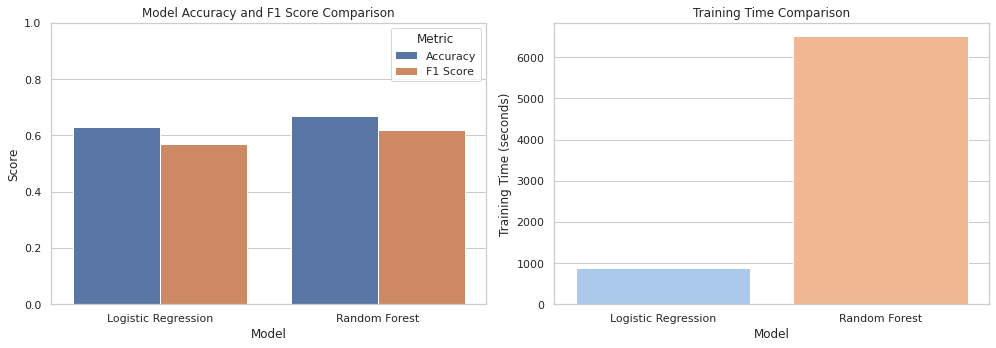

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the comparison data
data = {
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [0.63, 0.67],
    'F1 Score': [0.57, 0.62],
    'Training Time (s)': [879.00, 6512.40]
}

df = pd.DataFrame(data)

# Set plot style
sns.set(style="whitegrid")

# Plot 1: Accuracy and F1 Score side-by-side
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy and F1 Score barplot
df_melted = df.melt(id_vars='Model', value_vars=['Accuracy', 'F1 Score'], var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted, ax=axs[0])
axs[0].set_title('Model Accuracy and F1 Score Comparison')
axs[0].set_ylim(0, 1)

# Training time barplot
sns.barplot(x='Model', y='Training Time (s)', data=df, ax=axs[1], palette='pastel')
axs[1].set_title('Training Time Comparison')
axs[1].set_ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()


<b>Parallel Performance Benchmark (DDP + CPU)

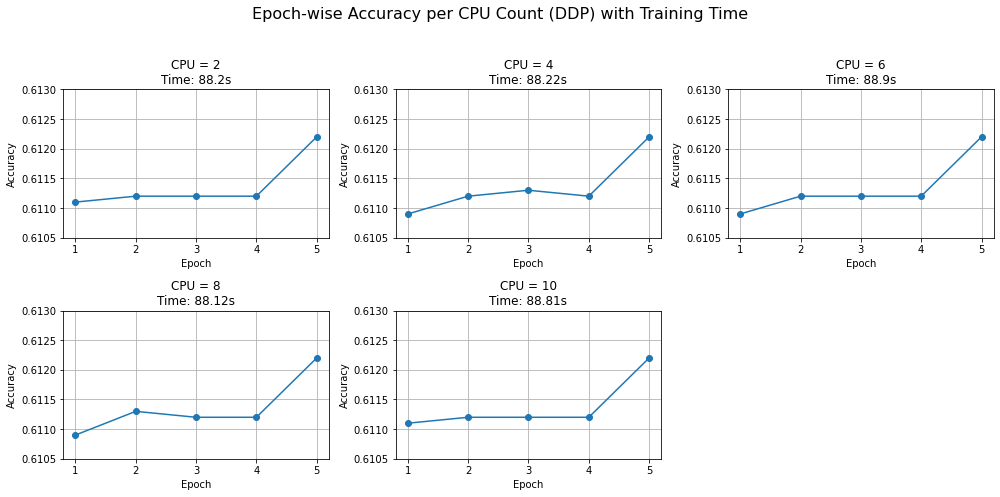

In [2]:
import matplotlib.pyplot as plt

# Accuracy values per CPU
cpu_2_acc = [0.6111, 0.6112, 0.6112, 0.6112, 0.6122]
cpu_4_acc = [0.6109, 0.6112, 0.6113, 0.6112, 0.6122]
cpu_6_acc = [0.6109, 0.6112, 0.6112, 0.6112, 0.6122]
cpu_8_acc = [0.6109, 0.6113, 0.6112, 0.6112, 0.6122]
cpu_10_acc = [0.6111, 0.6112, 0.6112, 0.6112, 0.6122]

# Corresponding training times (from screenshots)
training_times = [88.20, 88.22, 88.90, 88.12, 88.81]

cpus = [2, 4, 6, 8, 10]
accuracies = [cpu_2_acc, cpu_4_acc, cpu_6_acc, cpu_8_acc, cpu_10_acc]

# Plot 5 subplots with training time annotations
fig, axs = plt.subplots(2, 3, figsize=(14, 7))
axs = axs.flatten()

for i, acc in enumerate(accuracies):
    axs[i].plot(range(1, 6), acc, marker='o')
    axs[i].set_title(f"CPU = {cpus[i]}\nTime: {training_times[i]}s")
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim(0.6105, 0.613)
    axs[i].grid(True)

# Hide unused subplot
axs[-1].axis('off')

plt.suptitle("Epoch-wise Accuracy per CPU Count (DDP) with Training Time", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


<b>DDP+GPU

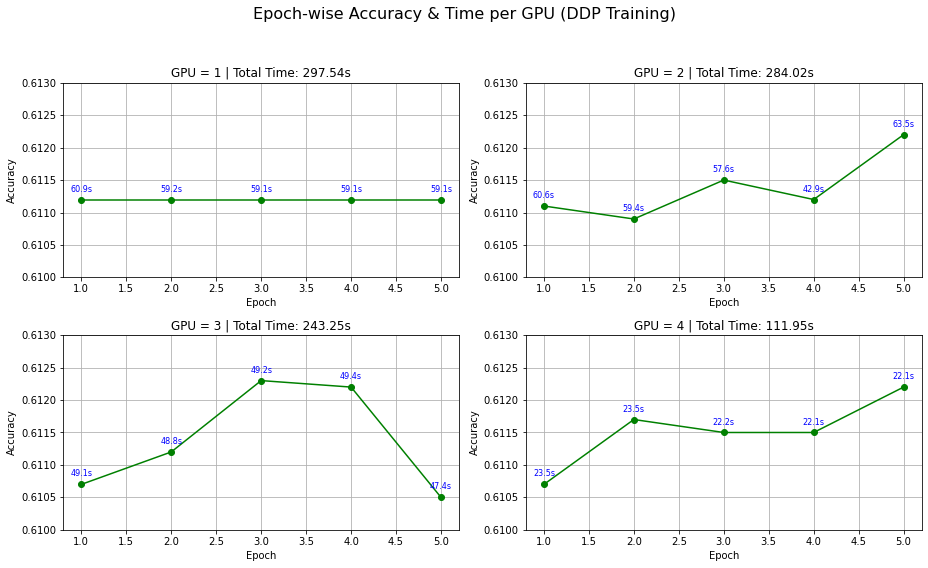

In [4]:
# Updated version with training time and epoch duration annotations per GPU

epoch_labels = ["Epoch 1", "Epoch 2", "Epoch 3", "Epoch 4", "Epoch 5"]

# Approximate time per epoch extracted from screenshots
gpu_1_times = [60.94, 59.17, 59.14, 59.13, 59.15]
gpu_2_times = [60.60, 59.38, 57.59, 42.93, 63.55]
gpu_3_times = [49.09, 48.81, 49.22, 49.38, 47.42]
gpu_4_times = [23.53, 23.53, 22.17, 22.13, 22.13]

gpu_accs = [gpu_1_acc, gpu_2_acc, gpu_3_acc, gpu_4_acc]
gpu_times = [297.54, 284.02, 243.25, 111.95]
epoch_times = [gpu_1_times, gpu_2_times, gpu_3_times, gpu_4_times]
gpu_labels = [1, 2, 3, 4]

# Plot with epoch and training time annotations
fig, axs = plt.subplots(2, 2, figsize=(13, 8))
axs = axs.flatten()

for i in range(4):
    axs[i].plot(range(1, 6), gpu_accs[i], marker='o', color='green')
    axs[i].set_title(f"GPU = {gpu_labels[i]} | Total Time: {gpu_times[i]}s")
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim(0.6100, 0.613)
    axs[i].grid(True)

    # Annotate time at each epoch
    for j, (x, y) in enumerate(zip(range(1, 6), gpu_accs[i])):
        axs[i].annotate(f"{epoch_times[i][j]:.1f}s", (x, y), textcoords="offset points", xytext=(0, 8),
                        ha='center', fontsize=8, color='blue')

plt.suptitle("Epoch-wise Accuracy & Time per GPU (DDP Training)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


<b>FSDP+GPU

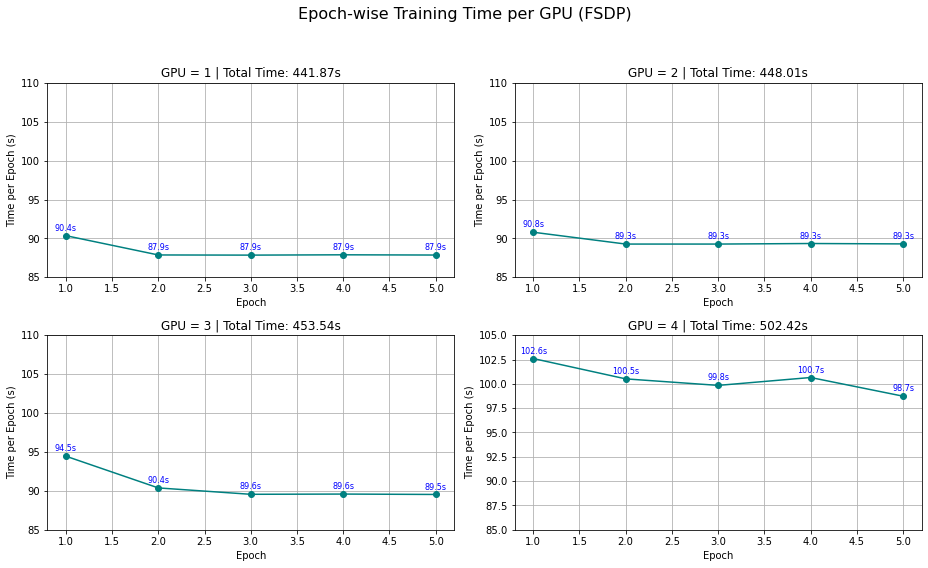

In [5]:
import matplotlib.pyplot as plt

# Training times per epoch extracted from screenshots
fsdp_gpu_1 = [90.36, 87.88, 87.86, 87.90, 87.87]
fsdp_gpu_2 = [90.80, 89.28, 89.28, 89.35, 89.30]
fsdp_gpu_3 = [94.46, 90.38, 89.56, 89.59, 89.54]
fsdp_gpu_4 = [102.60, 100.51, 99.84, 100.65, 98.73]

fsdp_total_times = [441.87, 448.01, 453.54, 502.42]
gpu_labels = [1, 2, 3, 4]
epoch_times = [fsdp_gpu_1, fsdp_gpu_2, fsdp_gpu_3, fsdp_gpu_4]

# Plot epoch vs epoch training time for each GPU
fig, axs = plt.subplots(2, 2, figsize=(13, 8))
axs = axs.flatten()

for i in range(4):
    axs[i].plot(range(1, 6), epoch_times[i], marker='o', color='teal')
    axs[i].set_title(f"GPU = {gpu_labels[i]} | Total Time: {fsdp_total_times[i]}s")
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel("Time per Epoch (s)")
    axs[i].set_ylim(85, 110 if i < 3 else 105)
    axs[i].grid(True)
    for j, t in enumerate(epoch_times[i]):
        axs[i].annotate(f"{t:.1f}s", (j + 1, t), textcoords="offset points", xytext=(0, 5),
                        ha='center', fontsize=8, color='blue')

plt.suptitle("Epoch-wise Training Time per GPU (FSDP)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


<b>Comparison GPU+DDP and GPU+FSDP

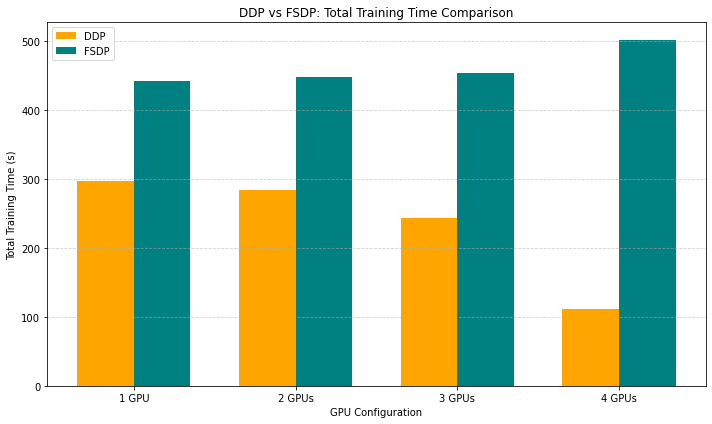

In [1]:
import matplotlib.pyplot as plt

# Total training times for DDP and FSDP on 1–4 GPUs
gpu_labels = ['1 GPU', '2 GPUs', '3 GPUs', '4 GPUs']
ddp_times = [297.54, 284.02, 243.25, 111.95]
fsdp_times = [441.87, 448.01, 453.54, 502.42]

x = range(len(gpu_labels))

# Plot grouped bar chart
bar_width = 0.35
plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], ddp_times, width=bar_width, label='DDP', color='orange')
plt.bar([i + bar_width/2 for i in x], fsdp_times, width=bar_width, label='FSDP', color='teal')

plt.xlabel("GPU Configuration")
plt.ylabel("Total Training Time (s)")
plt.title("DDP vs FSDP: Total Training Time Comparison")
plt.xticks(ticks=x, labels=gpu_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
